In [1]:
from torchvision import datasets
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0


In [2]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
dataset = datasets.ImageFolder('/content/drive/My Drive/CMPUT328_2020/Week08/Segmentation_by_classification', transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

examples = enumerate(dataloader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape,example_targets.shape)


torch.Size([100, 3, 32, 32]) torch.Size([100])


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        self.conv3 = nn.Conv2d(4, 2, kernel_size=5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        #print(x.shape)
        x = self.conv3(x).squeeze()
        #print(x.shape)
        return F.log_softmax(x,dim=1)

In [4]:
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=1e-2)

for itr in range(5):
  correct=0.0
  for batch_idx, (data, target) in enumerate(dataloader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # accuracy
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
  print(correct.item())

560.0
650.0
650.0
650.0
650.0


In [7]:

# Try trained model on flower image
flower = imread("/content/drive/My Drive/CMPUT328_2020/Week08/flower.jpg")

binary_seg = network(torch.tensor(2.0*flower/np.amax(flower)-1.0,dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)).permute(1,2,0)

print(binary_seg.shape)

torch.Size([99, 153, 2])


flower image shape (427, 640, 3)
segmented image shape torch.Size([99, 153, 2])


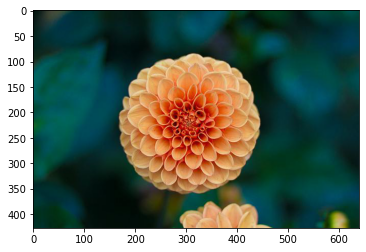

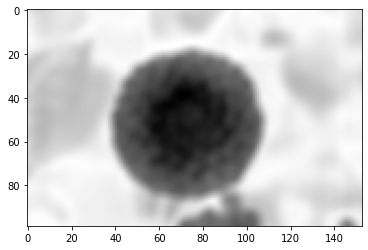

In [8]:

print("flower image shape",flower.shape)
print("segmented image shape",binary_seg.shape)
plt.imshow(flower)
plt.show()
plt.imshow(binary_seg[:,:,0].cpu().data,cmap="gray")
plt.show()